# Feature Extraction: HOG

## Setup

In [1]:
#import libraries
import webdataset as wds
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import cv2 as cv

from skimage.feature import hog
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
sns.set_theme(style="darkgrid")

In [3]:
#paths
root = '.'
data_folder = f'{root}/data'
feature_data_folder = f'{root}/feature_data/hog'

## Load Data

In [4]:
def load_data(path_to_data: str):
    """
    load 2D images and their labels

    returns: 
    images (array): array of images as np arrays
    labels (array): array of labels
    """
    #create lists to store images and labels
    images = []
    labels = []

    #load webdataset
    data = (wds.WebDataset(f'{path_to_data}', shardshuffle=True)
        .decode("pil")
        .to_tuple("jpg", "json")
        .map(lambda row: (np.array(row[0]), row[1]['label'])))

    #append dataset to lists
    for image, label in data:
        images.append(image)
        labels.append(label)

    images = np.array(images)
    labels = np.array(labels)
    data.close()

    return images, labels

In [5]:
train_images, train_labels = load_data(f'file:{data_folder}/train-000000.tar')
val_images, val_labels = load_data(f'file:{data_folder}/val-000000.tar')
test_images, test_labels = load_data(f'file:{data_folder}/test-000000.tar')

7


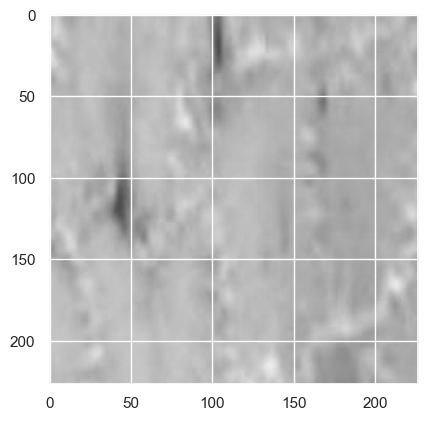

In [6]:
print(train_labels[0])
plt.imshow(train_images[0])

In [7]:
print("Shape of images:", train_images.shape)
print("Shape of labels:", train_labels.shape)

Shape of images: (8252, 227, 227, 3)
Shape of labels: (8252,)


## Quick EDA

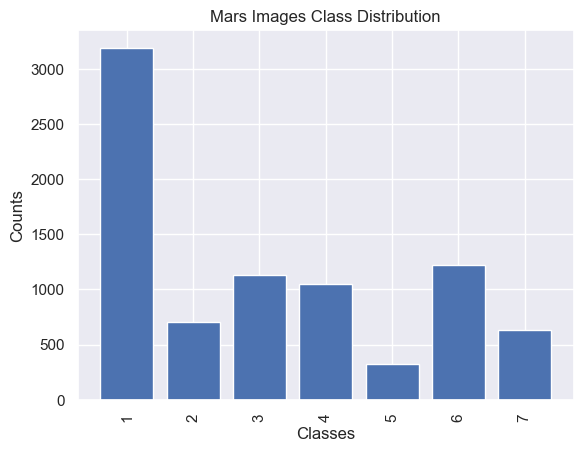

In [8]:
unique, counts = np.unique(train_labels, return_counts=True)
class_dict = dict(zip(unique, counts))
#plot
plt.bar(range(len(class_dict)), list(class_dict.values()), align='center')
plt.xticks(range(len(class_dict)), list(class_dict.keys()), rotation = 'vertical')
plt.title('Mars Images Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.show()

### View Class Samples

In [9]:
def plot_class_samples(images: list, labels: list):
    fig, axs = plt.subplots(nrows=1, ncols=len(images), figsize=(20,3))

    for i, (label, image) in enumerate(zip(labels, images)):
        ax = axs[i]
        ax.imshow(image)
        ax.set_title(label)
        ax.axis('off')

    fig.suptitle('One Image For Each Class')
    plt.show()

def load_class_samples(images: list, labels: list) -> tuple:
    label_names = ['crater', 'dark dune', 'slope streak', 'bright dune', 'impact ejecta', 'swiss cheese', 'spider']
    unique_labels = np.unique(labels)

    sample_images = []
    sample_labels = []

    for value in unique_labels:
        label = label_names[value - 1]
        index = int(np.where(train_labels==value)[0][0])

        sample_labels.append(label)
        sample_images.append(images[index])
    
    return sample_images, sample_labels

In [10]:
sample_imgs, sample_lbls = load_class_samples(train_images, train_labels)

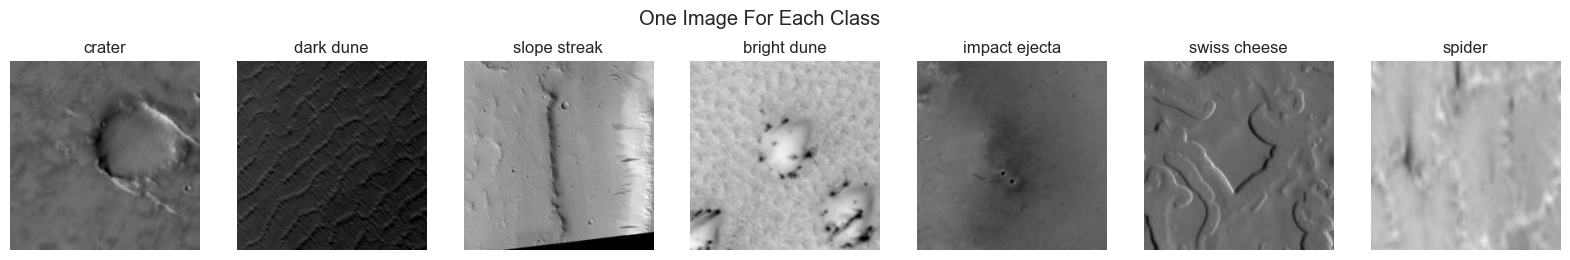

In [11]:
plot_class_samples(sample_imgs, sample_lbls)

## Feature Extraction: HOG

In [12]:
def get_hog_feature(imgs: list) -> tuple:
    hog_imgs = []
    hog_fts = []

    for img in imgs:
        img = cv.GaussianBlur(img, (5, 5), 0)
        img = cv.normalize(img, None, 0, 1, cv.NORM_MINMAX, cv.CV_32F)

        features, hog_img = hog(img, orientations=8, pixels_per_cell=(16, 16),
                        cells_per_block=(1, 1), visualize=True, channel_axis=-1)

        hog_imgs.append(hog_img)
        hog_fts.append(features)

    return np.array(hog_imgs), np.array(hog_fts)

def plot_hog_samples(sample_hogs: list, sample_labels: list):
    fig, axs = plt.subplots(nrows=1, ncols=len(sample_imgs), figsize=(20,3))

    samples = zip(sample_labels, sample_hogs)

    for i, (label, img) in enumerate(samples):
        ax = axs[i]
        ax.imshow(img)
        ax.set_title(label)
        ax.axis('off')

    fig.suptitle('SIFT Features per Class')
    plt.show()

### View Sift Sample

In [13]:
sample_hogs, sample_features = get_hog_feature(sample_imgs)

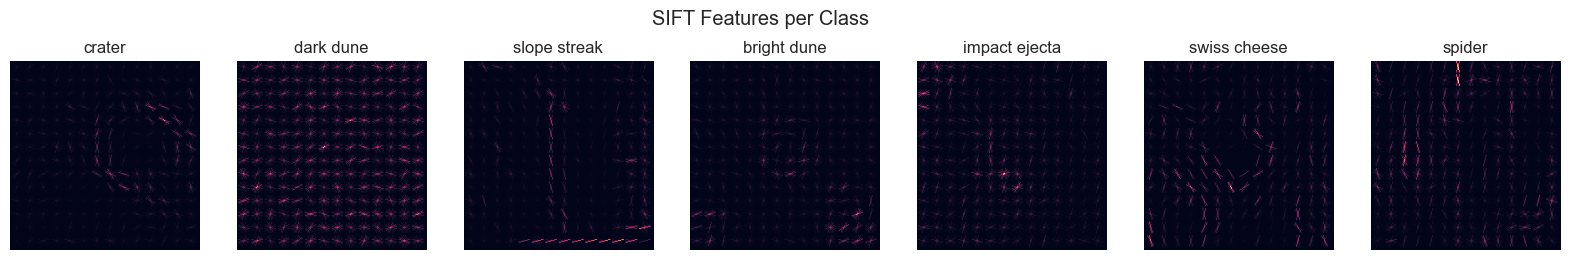

In [14]:
plot_hog_samples(sample_hogs, sample_lbls)

In [15]:
_, train_hog = get_hog_feature(train_images)
_, val_hog = get_hog_feature(val_images)
_, test_hog = get_hog_feature(test_images)

In [16]:
train_hog.shape, val_hog.shape, test_hog.shape

((8252, 1568), (2778, 1568), (152, 1568))

In [17]:
#save files
np.save(f'{feature_data_folder}/train_hog.npy', train_hog)
np.save(f'{feature_data_folder}/val_hog.npy', val_hog)
np.save(f'{feature_data_folder}/test_hog.npy', test_hog)

## PCA

In [18]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(train_hog)

In [19]:
pca = PCA()
pca.fit(train_hog)

PCA()

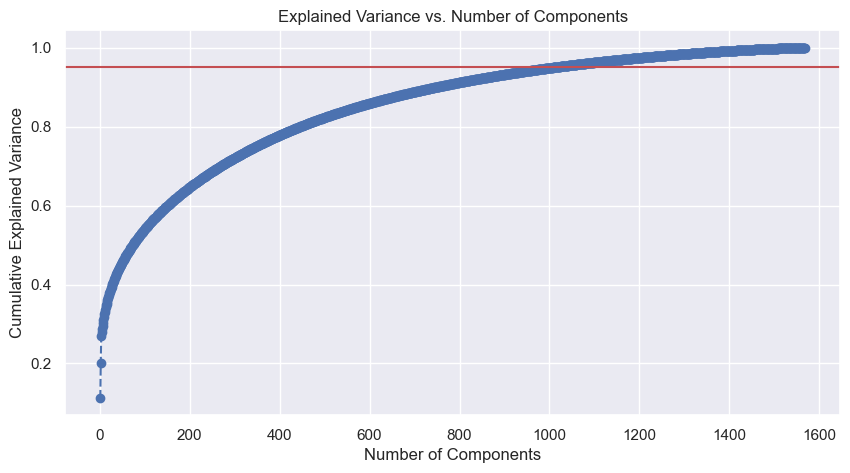

In [20]:
explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.axhline(y=0.95, color='r', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

## PCA down to 1000, $\approx 95\%$

In [21]:
pca = PCA(n_components=1000)
pca.fit(X_scaled)

PCA(n_components=1000)

In [22]:
train_hog = pca.transform(scaler.transform(train_hog))
val_hog = pca.transform(scaler.transform(val_hog))
test_hog = pca.transform(scaler.transform(test_hog))

In [23]:
np.save(f'{feature_data_folder}/train_hog.npy', train_hog)
np.save(f'{feature_data_folder}/val_hog.npy', val_hog)
np.save(f'{feature_data_folder}/test_hog.npy', test_hog)

## t-SNE

In [24]:
tsne = TSNE(n_components=2)
reduced_data = tsne.fit_transform(X_scaled)

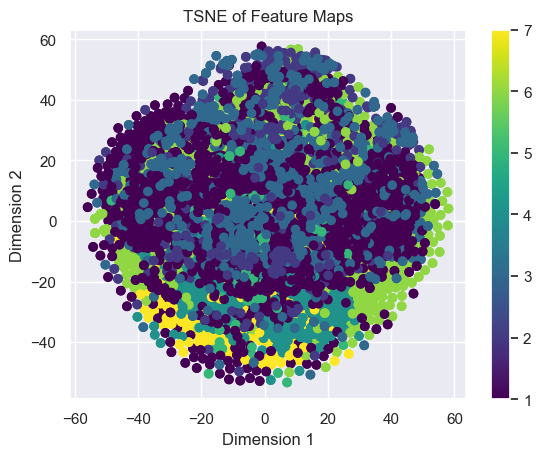

In [25]:
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=train_labels, cmap='viridis', marker='o')
plt.title('TSNE of Feature Maps')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.colorbar()
plt.show()

### Predictive Power

In [26]:
clf = LogisticRegression().fit(train_hog, train_labels)

C:\Users\linni\anaconda3\envs\comp_vision\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [27]:
clf.score(train_hog, train_labels)

0.8556713523994183

In [28]:
clf.score(val_hog, val_labels)

0.47264218862491003

In [29]:
preds = clf.predict(train_hog)
corr = preds == train_labels

In [30]:
df = pd.DataFrame({'correct': corr, 'label': train_labels})

In [31]:
df.head()

,correct,label
0,True,7
1,True,7
2,True,7
3,True,7
4,True,7


Text(0, 0.5, 'Count')

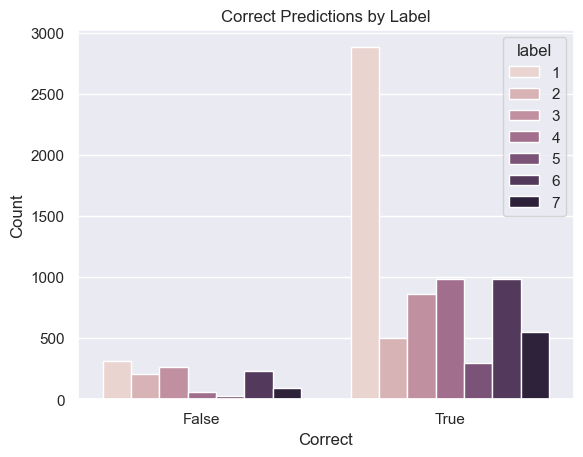

In [32]:
ax = sns.countplot(df, x='correct', hue='label')
ax.set_title('Correct Predictions by Label')
ax.set_xlabel('Correct')
ax.set_ylabel('Count')